# Voice Change

[この記事](https://qiita.com/KSRG_Miyabi/items/2a3b5bdca464ec1154d7)を参考に，実装してみた．

DiscoGAN（Learning to Discover Cross-Domain Relations　with Generative Adversarial Networks）の論文は[ここ](https://arxiv.org/pdf/1703.05192.pdf)．

タスク
* WGANのほうが良い？
    * RMSprop 
    * 1e-5?
* Batch_normalization

## import

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import cv2
import os
import random

import tensorflow as tf
import tflearn
from tflearn.layers.normalization import batch_normalization
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, upsample_2d
from tflearn.layers.merge_ops import merge

%matplotlib inline

/home/takiguchi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data Manager Class

In [2]:
class DataManager():
    
    def __init__(self):
        self.N = 256
        self.dif = 128
        self.window = np.hamming(self.N)
        self.im_width = 128
        
    def voice2images(self, data, folder_name):
        i = 0
        _wav = self.N + self.dif * (self.im_width - 1)
        _dif = int(_wav/2)
        while(True):
            _data = data[i*_dif:i*_dif + _wav]
            if (len(_data) < _wav):
                break
            self.save_image(self.spec2image(_data), folder_name + "/" + str(i) + ".png")
            i = i + 1
    
    def images2voice(self, folder_name):
        directory = os.listdir(folder_name)
        num_images = len(directory)
        _wav = self.N + self.dif * (self.im_width - 1)
        _dif = int(_wav/2)
        voice = np.zeros(_dif * (num_images+1))
        for i in range(num_images):
            data = self.read_image(folder_name + "/" + str(i) + ".png")
            if data is None:
                break
            voice[i*_dif:i*_dif+_wav] = voice[i*_dif:i*_dif+_wav] + self.image2spec(data)*np.r_[np.linspace(0,1,_dif), np.linspace(1,0,_dif)]
        
        """
        voice = []
        for i in range(image_num):
            data = self.read_image(folder_name + "/" + str(i) + ".png")
            voice.append(self.image2spec(data))
        """
        return voice
        
    def spec2image(self, data):
        image = []
        for i in range(self.im_width):
            image.append(self.dct(data[self.dif*i:self.dif*i + self.N]))
        return image
    
    def image2spec(self, data):
        voice = np.zeros(self.N + self.dif*(self.im_width-1))        
        vsum = np.zeros(self.N + self.dif*(self.im_width-1))
        for i in range(self.im_width):
            voice[self.dif*i:self.dif*i + self.N] = voice[self.dif*i:self.dif*i + self.N] + self.idct(data[i]) * self.window
            vsum[self.dif*i:self.dif*i + self.N] +=self.window ** 2 
        pos = (vsum != 0)
        voice[pos] /= vsum[pos]
        return voice
        
    def dct(self, data):       
        data = data * self.window
        data = scipy.fftpack.dct(data)
        pm = np.sign(data)
        data = np.log(np.abs(data)+0.0001)
        data = pm * data
        data = data[:int(self.N/2)]
        data = data / 20
        return data
    
    def idct(self, data):
        data = data * 20
        pm = np.sign(data)
        data = np.exp(np.abs(data))
        data = pm * data
        data = np.append(data, np.zeros(int(self.N/2)))
        data = scipy.fftpack.idct(data) / (2 * len(data))
        return data

    def read_wave(self, filename):
        wf = wave.open(filename , "r" )
        buf = wf.readframes(wf.getnframes())
        data = np.frombuffer(buf, dtype="int16") # 16 kHz?
        return data    
    
    def save_wave(self, data, filename):
        wf = wave.open(filename, "w")
        wf.setnchannels(2)
        wf.setsampwidth(2) #2 byte = 16 bit
        wf.setframerate(16000)
        wf.writeframes(np.array(data,  dtype="int16"))
        wf.close()
        
    def save_image(self, data, file_name):
        data = np.array(data) * 255
        cv2.imwrite(file_name, data)
        
    def read_image(self, file_name):
        data = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
        return data / 255
    
    def next_batch(self, num, folder_name):
        images = []
        directory = os.listdir(folder_name)
        num_images = len(directory)
        for i in range(num):
            image_num = random.randrange(0, num_images)
            image = self.read_image(folder_name + "/" + str(image_num) + ".png")
            images.append(image)
        return images

## Data init

In [3]:
dm = DataManager()

In [4]:
"""
voice1 = dm.read_wave("VoiceData/kamiya.wav")
voice2 = dm.read_wave("VoiceData/kizuna.wav")

dm.voice2images(voice1, "ImageData/Kamiya_images")
dm.voice2images(voice2, "ImageData/Kizuna_images")
"""

'\nvoice1 = dm.read_wave("VoiceData/kamiya.wav")\nvoice2 = dm.read_wave("VoiceData/kizuna.wav")\n\ndm.voice2images(voice1, "ImageData/Kamiya_images")\ndm.voice2images(voice2, "ImageData/Kizuna_images")\n'

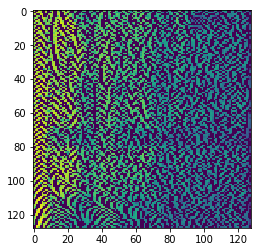

In [5]:
plt.imshow(dm.read_image("ImageData/Kamiya_images/1.png"))

In [6]:
"""
# Sample wav
voice = dm.images2voice("ImageData/Kamiya_images")
dm.save_wave(voice, "test.wav")
"""

'\n# Sample wav\nvoice = dm.images2voice("ImageData/Kamiya_images")\ndm.save_wave(voice, "test.wav")\n'

## Network

In [7]:
class DiscoGAN():
    
    def __init__(self, sess):
        
        self.sess = sess
                    
        self.x_1 = tflearn.input_data(shape=[None, 128, 128, 1])
        self.x_2 = tflearn.input_data(shape=[None, 128, 128, 1])
        
        self.gen_learning_rate = 1e-4
        self.dis_learning_rate = 1e-5
        
        self.param_gan = 0.1
        self.param_feat = 0.9
        self.param_recon = 1.
        
        self._create_optimizer()
        
        sess.run(tf.global_variables_initializer())
    
    def create_gen_network(self, network_name, inputs, reuse=None):
        with tf.variable_scope(network_name, reuse=reuse):
            
            conv1_1 = conv_2d(inputs, 32, 3, activation='relu')            
            conv1_2 = conv_2d(conv1_1, 32, 3, activation='relu')
            pool1 = max_pool_2d(conv1_2, 2)
            
            conv2_1 = conv_2d(pool1, 64, 3, activation='relu')            
            conv2_2 = conv_2d(conv2_1, 64, 3, activation='relu')
            pool2 = max_pool_2d(conv2_2, 2)
            
            conv3_1 = conv_2d(pool2, 128, 3, activation='relu')            
            conv3_2 = conv_2d(conv3_1, 128, 3, activation='relu')
            pool3 = max_pool_2d(conv3_2, 2)
            
            conv4_1 = conv_2d(pool3, 256, 3, activation='relu')            
            conv4_2 = conv_2d(conv4_1, 256, 3, activation='relu')
            pool4 = max_pool_2d(conv4_2, 2)

            conv5_1 = conv_2d(pool4, 512, 3, activation='relu')
            conv5_2 = conv_2d(conv5_1, 512, 3, activation='relu')
            
            up6 = conv_2d(upsample_2d(conv5_2, 2), 256, 2)
            merge6 = merge([up6, conv4_2], mode='concat', axis=3)
            conv6_1 = conv_2d(up6, 256, 3, activation='relu')
            conv6_2 = conv_2d(conv6_1, 256, 3, activation='relu')
            
            up7 = conv_2d(upsample_2d(conv6_2, 2), 128, 2)
            merge7 = merge([up7, conv3_2], mode='concat', axis=3)
            conv7_1 = conv_2d(up7, 128, 3, activation='relu')
            conv7_2 = conv_2d(conv7_1, 128, 3, activation='relu')
            
            up8 = conv_2d(upsample_2d(conv7_2, 2), 64, 2)
            merge8 = merge([up8, conv2_2], mode='concat', axis=3)
            conv8_1 = conv_2d(up8, 64, 3, activation='relu')
            conv8_2 = conv_2d(conv8_1, 64, 3, activation='relu')
            
            up9 = conv_2d(upsample_2d(conv8_2, 2), 32, 2)
            merge9 = merge([up9, conv1_2], mode='concat', axis=3)
            conv9_1 = conv_2d(up9, 32, 3, activation='relu')
            conv9_2 = conv_2d(conv9_1, 32, 3, activation='relu')
            
            conv9_3 = conv_2d(conv9_2, 2, 3, activation='relu')
            
            outputs = conv_2d(conv9_3, 1, 1, activation='sigmoid')
            
        return outputs
        
    def create_dis_network(self, network_name, inputs, reuse=None):
        with tf.variable_scope(network_name, reuse=reuse):
            
            network = conv_2d(inputs, 64, 1,  activation='relu')
            network = conv_2d(network, 128, 1, activation='relu')
            network = conv_2d(network, 256, 1, activation='relu')
            network = conv_2d(network, 512, 1, activation='relu')
            #network = fully_connected(network, 256, activation='relu')
            outputs = fully_connected(network, 1, activation='sigmoid')
            
        return outputs, network
    
    def compute_loss_gan(self, y_real, y_fake):
        """
        batchsize = y_real.shape[0]
        loss_dis = F.sum(F.softplus(-y_real) + F.softplus(y_fake))
        loss_gen = F.sum(F.softplus(-y_fake))
        return loss_dis / batchsize, loss_gen / batchsize
        
        ones = tf.random_uniform(shape=tf.shape(y_real), minval=0.7,maxval=1.2,dtype=tf.float32)
        zeros = tf.random_uniform(shape=tf.shape(y_real), minval=0.0,maxval=0.3,dtype=tf.float32)
        loss_dis =  tflearn.mean_square(y_real, ones) + tflearn.mean_square(y_fake, zeros)
        loss_gen = tflearn.mean_square(y_fake, ones)
        
        loss_dis =  -tf.reduce_mean(tf.log(y_real) + tf.log(1. - y_fake))
        loss_gen = -tf.reduce_mean(tf.log(y_fake))
        """ 
        y_real = tf.clip_by_value(y_real, 1e-10, 1.0)
        y_fake = tf.clip_by_value(y_fake, 1e-10, 1.0)

        loss_dis =  -tf.reduce_mean(tf.log(y_real) + tf.log(1. - y_fake))
        loss_gen = -tf.reduce_mean(tf.log(y_fake))
        return loss_dis, loss_gen

    def compute_loss_feat(self, feats_real, feats_fake):
        """
        losses = 0
        for feat_real, feat_fake in zip(feats_real, feats_fake):
        feat_real_mean = tf.reduce_sum(feat_real, 0) / feat_real.shape[0]
        feat_fake_mean = tf.reduce_sum(feat_fake, 0) / feat_fake.shape[0]
        l2 = (feat_real_mean - feat_fake_mean) ** 2
        loss = tf.reduce_sum(l2) / l2.size
        losses += loss
        return losses
        """
        return tflearn.mean_square(feats_real, feats_fake)
        
    
    def _create_optimizer(self):

        self.x_12 = self.create_gen_network("G1", self.x_1)
        self.x_21 = self.create_gen_network("G2", self.x_2)

        self.x_121 = self.create_gen_network("G2", self.x_12, reuse=True)
        self.x_212 = self.create_gen_network("G1", self.x_21, reuse=True)

        recon_loss_1 = tflearn.mean_square(self.x_1, self.x_121)
        recon_loss_2 = tflearn.mean_square(self.x_2, self.x_212)

        y_1_real, feats_1_real = self.create_dis_network("D1", self.x_1)
        y_1_fake, feats_1_fake = self.create_dis_network("D1", self.x_21, reuse=True)

        y_2_real, feats_2_real = self.create_dis_network("D2", self.x_2)
        y_2_fake, feats_2_fake = self.create_dis_network("D2", self.x_12, reuse=True)

        feat_loss_1 = self.compute_loss_feat(feats_1_real, feats_1_fake)
        feat_loss_2 = self.compute_loss_feat(feats_2_real, feats_2_fake)
        
        gan_loss_dis_1, gan_loss_gen_1 = self.compute_loss_gan(y_1_real, y_1_fake)
        gan_loss_dis_2, gan_loss_gen_2 = self.compute_loss_gan(y_2_real, y_2_fake)
        
        # gan = 0.1
        # feat = 0.9
        # recon = 1

        total_loss_gen_1 = self.param_gan*gan_loss_gen_2 + self.param_feat*feat_loss_2 + self.param_recon*recon_loss_1
        total_loss_gen_2 = self.param_gan*gan_loss_gen_1 + self.param_feat*feat_loss_1 + self.param_recon*recon_loss_2
        
        self.gen_loss = total_loss_gen_1 + total_loss_gen_2
        self.dis_loss = gan_loss_dis_1 + gan_loss_dis_2
        
        self.gen_loss = total_loss_gen_1 + total_loss_gen_2
        self.dis_loss = gan_loss_dis_1 + gan_loss_dis_2
        
        self.gen_optimize = tf.train.AdamOptimizer(self.gen_learning_rate).minimize(
            loss=self.gen_loss
        )
        self.dis_optimize = tf.train.AdamOptimizer(self.dis_learning_rate).minimize(
            loss=self.dis_loss
        )
        
    def optimize_gen(self, x_1, x_2):
        self.sess.run(self.gen_optimize, feed_dict={
            self.x_1: x_1,
            self.x_2: x_2
        }) 
    def optimize_dis(self, x_1, x_2):
        self.sess.run(self.dis_optimize, feed_dict={
            self.x_1: x_1,
            self.x_2: x_2
        }) 
        
    def gen1(self, image):
        return self.sess.run(self.x_12, feed_dict={
            self.x_1: image,
        }) 

    def gen2(self, image):
        return self.sess.run(self.x_21, feed_dict={
            self.x_2: image,
        }) 

## Train & Test

In [8]:
def train(sess, discoGAN, epoch, batch_size):
        
    for i in range(epoch):
        if ((i+1) % 50 == 0):
            print(str(i+1) + "/" + str(epoch))
        if ((i+1) % 10 == 0):
            test(sess, discoGAN, "ImageData/Kamiya_images/100.png")
            
        images1 = dm.next_batch(batch_size, "ImageData/Kamiya_images")
        images2 = dm.next_batch(batch_size, "ImageData/Kizuna_images")
        images1 = np.reshape(images1, (-1, 128, 128, 1))
        images2 = np.reshape(images2, (-1, 128, 128, 1))

        if (i % 3 == 0):
            discoGAN.optimize_dis(images1, images2)
        else:
            discoGAN.optimize_gen(images1, images2)
            
def test(sess, discoGAN, file_name):
    
    image = dm.read_image(file_name)
    gen_image = discoGAN.gen1(np.reshape(image, (-1, 128, 128, 1)))
    gen_image = np.reshape(gen_image, (128, 128))

    plt.title("original")
    plt.imshow(image)
    plt.show()
    plt.title("generated")
    plt.imshow(gen_image)
    plt.show()
        
def gen_voice(sess, discoGAN, num):
    
    for i in range(num):
        image = dm.read_image("ImageData/Kamiya_images/" + str(i) + ".png")
        gen_image = discoGAN.gen1(np.reshape(image, (-1, 128, 128, 1)))
        gen_image = np.reshape(gen_image, (128, 128))
        dm.save_image(gen_image, "ImageData/Kamiya_to_Kizuna_images/" + str(i) + ".png")
    
    voice = dm.images2voice("ImageData/Kamiya_to_Kizuna_images")
    dm.save_wave(voice, "gen.wav")    

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


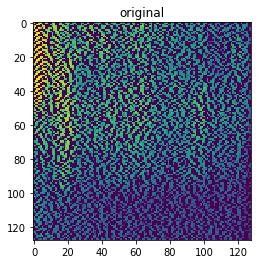

/home/takiguchi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/takiguchi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


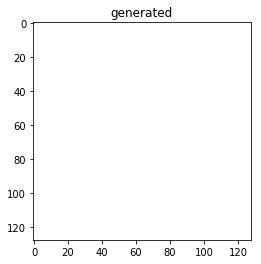

KeyboardInterrupt: 

In [9]:
with tf.Session() as sess:
        
    discoGAN = DiscoGAN(sess)
    train(sess, discoGAN, epoch=1000, batch_size=1)
    test(sess, discoGAN, "ImageData/Kamiya_images/100.png")
    gen_voice(sess, discoGAN, 100)